# 3. Mastery Map Visualization

Visualize attempts×successes mastery regions under chosen priors and thresholds.


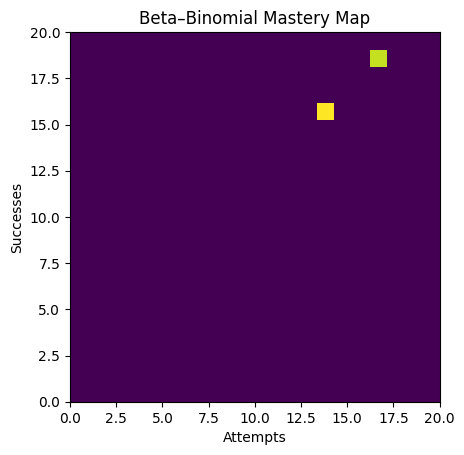

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

alpha_prior, beta_prior = 2.0, 2.0
familiar, proficient, confidence = 0.3, 0.5, 0.8
max_attempts = 20

def posterior_params(a0, b0, n, k):
    return a0 + k, b0 + (n-k)

def ci_low(a, b, conf):
    return beta.ppf((1-conf)/2, a, b)

grid = np.empty((max_attempts+1, max_attempts+1))
for n in range(max_attempts+1):
    for k in range(n+1):
        a, b = posterior_params(alpha_prior, beta_prior, n, k)
        low = ci_low(a, b, confidence)
        grid[n, k] = 2 if low >= proficient else (1 if low >= familiar else 0)

plt.imshow(grid.T, origin='lower', extent=[0, max_attempts, 0, max_attempts], aspect='equal', cmap='viridis')
plt.xlabel('Attempts')
plt.ylabel('Successes')
plt.title('Beta–Binomial Mastery Map')
plt.show()
